In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import urllib.request as request


D:\PyTorch\PyTorch_Tutorial\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
    def __init__(self):
        self.ROOT_DATA_DIR="hymenoptera_data"
        self.EPOCH=20
        self.BATCH_SIZE=32
        self.LEARNING_RATE=0.01
        self.IMAGE_SIZE=(224,224)
        self.DEVICE="cuda" if torch.cuda.is_available() else "cpu"
        print(f"This notebook is using device: {self.DEVICE}")
        self.SEED=42
    def create_dir(self,dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print(f"{dir_path} directory is created")
config=Config()

This notebook is using device: cpu


# Download Data

In [41]:
data_URL="https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [42]:
config.create_dir(dir_path=config.ROOT_DATA_DIR)

hymenoptera_data directory is created


In [43]:
data_zip_file="data.zip"
data_file_path=os.path.join(config.ROOT_DATA_DIR,data_zip_file)
request.urlretrieve(data_URL, data_file_path)


('hymenoptera_data\\data.zip', <http.client.HTTPMessage at 0x15b14cb7848>)

In [44]:
from zipfile import ZipFile
def unzip_file(source: str, dest:str) -> None:
    print(f"extraction started.......")
    with ZipFile(source, "r") as zip_f:
        zip_f.extractall(dest)
    print(f"extracted {source} to {dest}")

In [45]:
unzip_file(data_file_path, config.ROOT_DATA_DIR)

extraction started.......
extracted hymenoptera_data\data.zip to hymenoptera_data


In [46]:
!ls hymenoptera_data/hymenoptera_data/train

ants
bees


In [47]:
Path("hymenoptera_data/hymenoptera_data/train")

WindowsPath('hymenoptera_data/hymenoptera_data/train')

In [7]:
from pathlib import Path

In [8]:
train_path=Path("hymenoptera_data/hymenoptera_data/train")
test_path=Path("hymenoptera_data/hymenoptera_data/val")

# mean of the each channel of the image
#### for 28,28 img size
1.  mean=sum(value of the pixels)/784
2. std=(data-mean(/std

In [9]:
mean=torch.tensor([0.5,0.5,0.5])
std=torch.tensor([0.5,0.5,0.5])

In [10]:
train_transforms=transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])
test_transforms=transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])

In [11]:
train_data=datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data=datasets.ImageFolder(root=train_path, transform=test_transforms)

In [12]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [13]:
label_map=train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [15]:
test_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

# Create data loader

In [16]:
train_loader=DataLoader(train_data, shuffle=True, batch_size=config.BATCH_SIZE)
test_data=DataLoader(test_data, shuffle=False, batch_size=config.BATCH_SIZE)

In [17]:
data=next(iter(train_loader))

In [18]:
len(data)

2

In [19]:
images, labels=data

In [20]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Visualize one of the Samples

In [21]:
img=images[0]
img.shape

torch.Size([3, 224, 224])

TypeError: Invalid shape (3, 224, 224) for image data

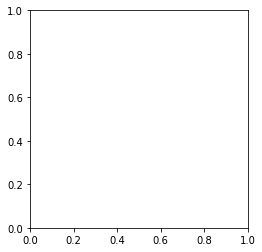

In [22]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


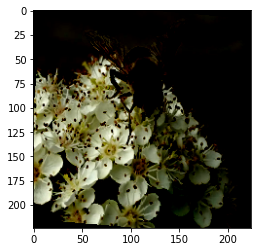

In [23]:
plt.imshow(img.permute(1,2,0))# permute->exchange first index with last index----output will be->[224,224,3]

In [66]:
models.AlexNet

torchvision.models.alexnet.AlexNet

# Download and use pre_trained model for transfer learning

In [24]:
model=models.AlexNet(pretrained=True)

TypeError: __init__() got an unexpected keyword argument 'pretrained'

In [25]:
model=models.alexnet(pretrained=True)# ImageNet dataset

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\kulki/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████████████████████████████████| 233M/233M [01:32<00:00, 2.64MB/s]


In [26]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
def count_params(model):
    model_params={"Modules":list(), "Parameters":list()}
    total={"trainable":0,"non_trainable":0}
    for name, parameters in model.named_parameters():
        param=parameters.numel()
        if not parameters.requires_grad:
            total["non_trainable"] +=param
            continue
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total["trainable"] +=param
    df=pd.DataFrame(model_params)
    df=df.style.set_caption(f"Total parameters: {total}")
    return df
count_params(model)

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


# Freeze all the layers

In [30]:
for parameters in model.parameters():
    """
    requires_grad-> its ready to be backward propagation. calculating gradient in every steps and after when we go with optimizer steps,
    it will update the weights
    """
    print(parameters.requires_grad)
    parameters.requires_grad=False

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [31]:
count_params(model)

,Modules,Parameters


# Acces the last classifier

In [32]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [33]:
model.classifier=nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [34]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [35]:
count_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


# Training Loop

In [36]:
model.to(config.DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

# Define the loss function

In [37]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [39]:
for epoch in range(config.EPOCH):
    with tqdm(train_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch+1}/{config.DEVICE}")
            images=images.to(config.DEVICE)
            labels=labels.to(config.DEVICE)
            
            # Forward pass
            outputs=model(images)
            loss=criterion(outputs, labels)
            # backword pass we have to zero the gradient
            optimizer.zero_grad()#
            """
            zero_grad->let say if you are in the middle of 2nd or 3rd epochs, previous gradient(residual gradient) you might calculated.
            That is already in updated let see when we go with optimizer.step() its already update the weights by using the gradient that has been calculated.
            So next time if we dont do zero gradient
            """
            loss.backward()
            optimizer.step()
            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 20/cpu: 100%|███████████████| 8/8 [00:05<00:00,  1.45it/s, loss=0.00639]


# Evaluate our model